In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM#, CuDNNLSTM
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.python.framework import ops
import matplotlib.pyplot as plt
import numpy as np
ops.reset_default_graph()

D:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [8]:
mnist= input_data.read_data_sets('temp', one_hot=False)

Extracting temp\train-images-idx3-ubyte.gz
Extracting temp\train-labels-idx1-ubyte.gz
Extracting temp\t10k-images-idx3-ubyte.gz
Extracting temp\t10k-labels-idx1-ubyte.gz


In [9]:
train_x = np.array([np.reshape(x, (28,28)) for x in mnist.train.images])
test_x = np.array([np.reshape(x, (28,28)) for x in mnist.test.images])
train_y = mnist.train.labels
test_y = mnist.test.labels

In [10]:
batch_size = 100
eval_every = 5
generations = 5000
learning_rate = 0.001
evaluation_size = 500
eval_indices = range(0, generations, eval_every)

In [11]:
steps_per_epoch = 2000

In [12]:
x_train.shape

(60000, 28, 28)

In [13]:
def model_build_1(model, DROP_OUT):
    
    model.add(Dense(32, activation='relu'))
    if DROP_OUT:
        model.add(Dropout(0.2))

    model.add(Dense(10, activation='softmax'))


In [32]:
### https://stackoverflow.com/questions/42755820/how-to-use-return-sequences-option-and-timedistributed-layer-in-keras

### LSTM will eat the words of your sentence one by one, you can chose via "return_sequence" to outuput something (the state) at each step (after each word processed) or only output something after the last word has been eaten. So with return_sequence=TRUE, the output will be a sequence of the same length, with return_sequence=FALSE, the output will be just one vector.

In [14]:
def model_build_2(model, train_data, DROP_OUT):
    model.add(LSTM(128, input_shape=(train_data.shape[1:]), activation='relu', return_sequences=True))
    if DROP_OUT:
        model.add(Dropout(0.2))

    model.add(LSTM(128, activation='relu'))
    if DROP_OUT:
        model.add(Dropout(0.1))

    model.add(Dense(32, activation='relu'))
    if DROP_OUT:
        model.add(Dropout(0.2))

    model.add(Dense(10, activation='softmax'))


In [31]:
### https://keras.io/optimizers/

In [16]:
def model_run(MODEL_NAME, train_data, train_labels, test_data, test_labels, batch_size, generations, learning_rate = 0, DROP_OUT = False, OPT = 'RMS'):
    
    model = Sequential()

    if MODEL_NAME == 'NN_2':
        train_data = np.array([x.reshape([28*28,]) for x in train_data])
        test_data = np.array([x.reshape([28*28,]) for x in test_data])
        model_build_1(model, DROP_OUT)
        
    elif MODEL_NAME == 'LSTM_2_NN_2':
        model_build_2(model, train_data, DROP_OUT)
    else:
        print('Model name not exist')
        
    
    # compare different optimizer https://keras.io/optimizers/
    if learning_rate == 0:
        if OPT == 'ADM':
            opt = tf.keras.optimizers.Adam()
        elif OPT == 'RMS':
            opt = tf.keras.optimizers.RMSprop()
        elif OPT == 'SGD':
            opt = tf.keras.optimizers.SGD()
        elif OPT == 'ADA':
            opt = opt = tf.keras.optimizers.SGD()
    else:
        if OPT == 'ADM':
            opt = tf.keras.optimizers.Adam(lr = learning_rate)
        elif OPT == 'RMS':
            opt = tf.keras.optimizers.RMSprop(lr = learning_rate)
        elif OPT == 'SGD':
            opt = tf.keras.optimizers.SGD(lr = learning_rate)
        elif OPT == 'ADA':
            opt = opt = tf.keras.optimizers.SGD(lr = learning_rate)

    
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    train_acc = []
    test_acc = []
    train_loss = []
    test_loss = []

    for i in range(generations):
            rand_index = np.random.choice(len(train_data), size=batch_size)
            #print(rand_index)
            rand_x = train_data[rand_index]
            rand_y = train_labels[rand_index]
            #print(rand_x.shape)
            #print(rand_y.shape)
                
            if (i+1) % eval_every == 0:
                eval_index = np.random.choice(len(test_data), size=evaluation_size)
                eval_x = test_data[eval_index]
                eval_y = test_labels[eval_index]

                history_test = model.fit(rand_x, rand_y, batch_size = batch_size, validation_data=(eval_x, eval_y), verbose = 0)

                # Record and print results
                train_loss.append(*history_train.history['loss'])
                train_acc.append(*history_train.history['acc'])
                test_loss.append(*history_test.history['loss'])
                test_acc.append(*history_test.history['acc'])

                acc_and_loss = [i + 1, *history_train.history['loss'], *history_test.history['loss'], *history_train.history['acc'], *history_test.history['acc']]
            else:
                history_train = model.fit(rand_x, rand_y, batch_size = batch_size, verbose = 0)

            if (i+1) % 200 == 0:
                print('Generation # {}. Train Loss (Test Loss): {:.2f} ({:.2f}). Train Acc (Test Acc): {:.2f} ({:.2f})'.format(*acc_and_loss))
    return [train_loss, test_loss, train_acc, test_acc]

## NN model (Fully_con_1 -> Fully_con_2)

### Dropput vs Non-Dropout

In [265]:
a_l_nn_2_nd_rms = model_run('NN_2', train_x, train_y, test_x, test_y, batch_size, generations, learning_rate, DROP_OUT = False)

Generation # 200. Train Loss (Test Loss): 0.47 (0.39). Train Acc (Test Acc): 0.84 (0.90)
Generation # 400. Train Loss (Test Loss): 0.48 (0.33). Train Acc (Test Acc): 0.88 (0.89)
Generation # 600. Train Loss (Test Loss): 0.25 (0.28). Train Acc (Test Acc): 0.94 (0.91)
Generation # 800. Train Loss (Test Loss): 0.20 (0.29). Train Acc (Test Acc): 0.95 (0.93)
Generation # 1000. Train Loss (Test Loss): 0.19 (0.26). Train Acc (Test Acc): 0.96 (0.93)
Generation # 1200. Train Loss (Test Loss): 0.61 (0.14). Train Acc (Test Acc): 0.87 (0.96)
Generation # 1400. Train Loss (Test Loss): 0.13 (0.21). Train Acc (Test Acc): 0.97 (0.94)
Generation # 1600. Train Loss (Test Loss): 0.45 (0.23). Train Acc (Test Acc): 0.91 (0.94)
Generation # 1800. Train Loss (Test Loss): 0.16 (0.10). Train Acc (Test Acc): 0.93 (0.95)
Generation # 2000. Train Loss (Test Loss): 0.12 (0.17). Train Acc (Test Acc): 0.96 (0.94)
Generation # 2200. Train Loss (Test Loss): 0.16 (0.23). Train Acc (Test Acc): 0.96 (0.94)
Generation # 2

In [266]:
a_l_nn_2_d_rms = model_run('NN_2', train_x, train_y, test_x, test_y, batch_size, generations, learning_rate, DROP_OUT = True)

Generation # 200. Train Loss (Test Loss): 0.37 (0.46). Train Acc (Test Acc): 0.91 (0.86)
Generation # 400. Train Loss (Test Loss): 0.26 (0.21). Train Acc (Test Acc): 0.93 (0.93)
Generation # 600. Train Loss (Test Loss): 0.18 (0.27). Train Acc (Test Acc): 0.97 (0.91)
Generation # 800. Train Loss (Test Loss): 0.39 (0.17). Train Acc (Test Acc): 0.89 (0.96)
Generation # 1000. Train Loss (Test Loss): 0.27 (0.14). Train Acc (Test Acc): 0.94 (0.94)
Generation # 1200. Train Loss (Test Loss): 0.28 (0.25). Train Acc (Test Acc): 0.92 (0.95)
Generation # 1400. Train Loss (Test Loss): 0.14 (0.27). Train Acc (Test Acc): 0.95 (0.91)
Generation # 1600. Train Loss (Test Loss): 0.20 (0.10). Train Acc (Test Acc): 0.94 (0.97)
Generation # 1800. Train Loss (Test Loss): 0.10 (0.14). Train Acc (Test Acc): 0.97 (0.95)
Generation # 2000. Train Loss (Test Loss): 0.22 (0.20). Train Acc (Test Acc): 0.92 (0.96)
Generation # 2200. Train Loss (Test Loss): 0.19 (0.12). Train Acc (Test Acc): 0.96 (0.95)
Generation # 2

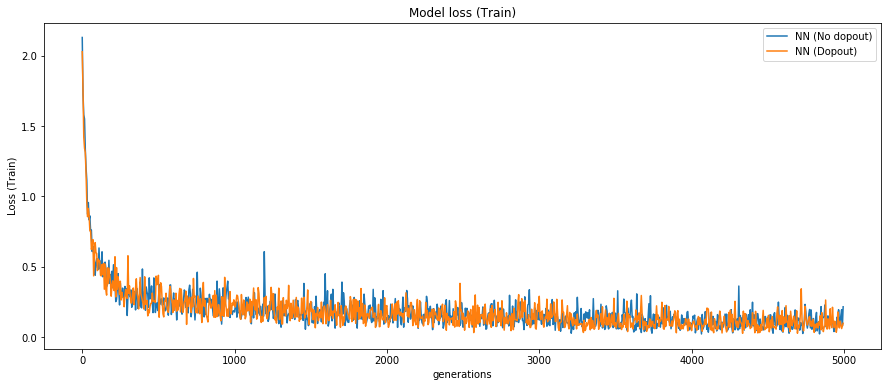

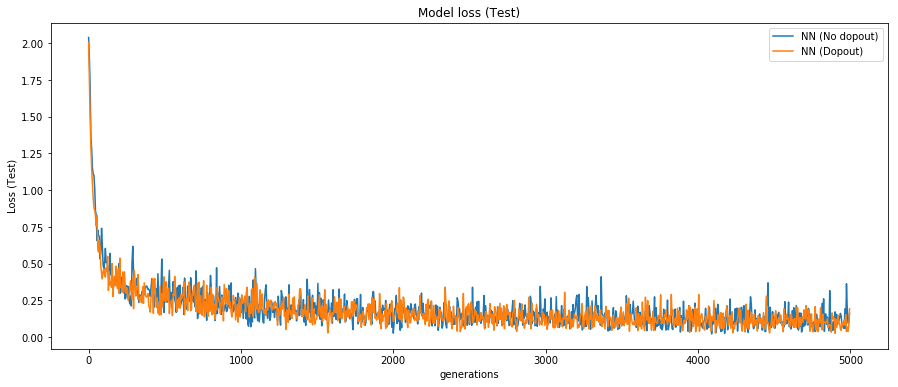

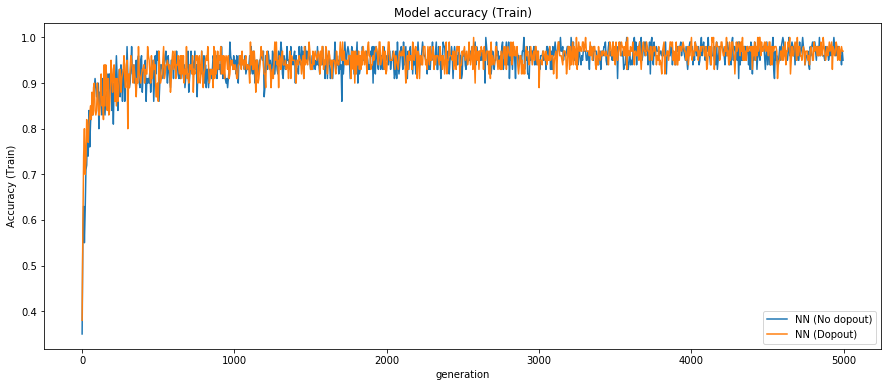

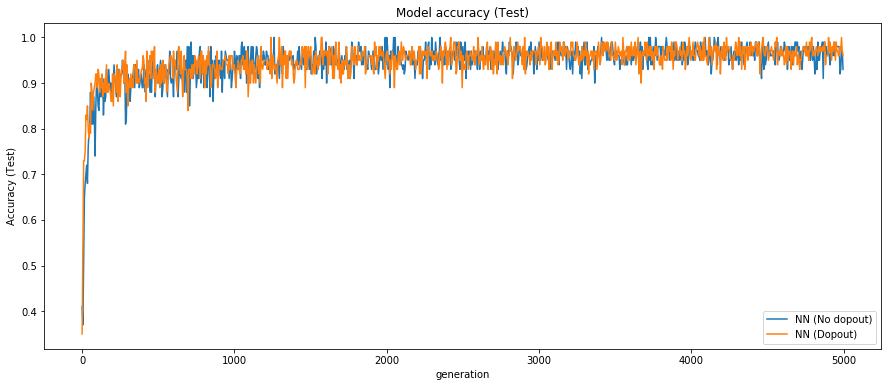

In [267]:
plt.rcParams["figure.figsize"] = [15,6]

plt.plot(eval_indices, a_l_nn_2_nd_rms[0])
plt.plot(eval_indices, a_l_nn_2_d_rms[0])
plt.title('Model loss (Train)')
plt.ylabel('Loss (Train)')
plt.xlabel('generations')
plt.legend(['NN (No dopout)', 'NN (Dopout)'], loc='upper right')
plt.show()

plt.plot(eval_indices, a_l_nn_2_nd_rms[1])
plt.plot(eval_indices, a_l_nn_2_d_rms[1])
plt.title('Model loss (Test)')
plt.ylabel('Loss (Test)')
plt.xlabel('generations')
plt.legend(['NN (No dopout)', 'NN (Dopout)'], loc='upper right')
plt.show()

plt.plot(eval_indices, a_l_nn_2_nd_rms[2])
plt.plot(eval_indices, a_l_nn_2_d_rms[2])
plt.title('Model accuracy (Train)')
plt.ylabel('Accuracy (Train)')
plt.xlabel('generation')
plt.legend(['NN (No dopout)', 'NN (Dopout)'], loc='lower right')
plt.show()

plt.plot(eval_indices, a_l_nn_2_nd_rms[3])
plt.plot(eval_indices, a_l_nn_2_d_rms[3])
plt.title('Model accuracy (Test)')
plt.ylabel('Accuracy (Test)')
plt.xlabel('generation')
plt.legend(['NN (No dopout)', 'NN (Dopout)'], loc='lower right')
plt.show()

#### Drop out dont have significant effect on NN_2

### Compare different optimizers for NN with default learning_rate

In [ ]:
%%time
a_l_nn_2_d_rms = model_run('NN_2', train_x, train_y, test_x, test_y, batch_size, generations, DROP_OUT = True, OPT = 'RMS')

In [271]:
%%time
a_l_nn_2_d_adm = model_run('NN_2', train_x, train_y, test_x, test_y, batch_size, generations, DROP_OUT = True, OPT = 'ADM')

Generation # 200. Train Loss (Test Loss): 0.31 (0.44). Train Acc (Test Acc): 0.91 (0.89)
Generation # 400. Train Loss (Test Loss): 0.25 (0.31). Train Acc (Test Acc): 0.94 (0.91)
Generation # 600. Train Loss (Test Loss): 0.46 (0.22). Train Acc (Test Acc): 0.88 (0.92)
Generation # 800. Train Loss (Test Loss): 0.24 (0.25). Train Acc (Test Acc): 0.92 (0.92)
Generation # 1000. Train Loss (Test Loss): 0.23 (0.21). Train Acc (Test Acc): 0.93 (0.95)
Generation # 1200. Train Loss (Test Loss): 0.14 (0.22). Train Acc (Test Acc): 0.96 (0.96)
Generation # 1400. Train Loss (Test Loss): 0.23 (0.15). Train Acc (Test Acc): 0.94 (0.96)
Generation # 1600. Train Loss (Test Loss): 0.18 (0.19). Train Acc (Test Acc): 0.93 (0.95)
Generation # 1800. Train Loss (Test Loss): 0.15 (0.17). Train Acc (Test Acc): 0.95 (0.94)
Generation # 2000. Train Loss (Test Loss): 0.15 (0.42). Train Acc (Test Acc): 0.95 (0.89)
Generation # 2200. Train Loss (Test Loss): 0.20 (0.09). Train Acc (Test Acc): 0.97 (0.98)
Generation # 2

In [272]:
%%time
a_l_nn_2_d_sgd = model_run('NN_2', train_x, train_y, test_x, test_y, batch_size, generations, DROP_OUT = True, OPT = 'SGD')

Generation # 200. Train Loss (Test Loss): 1.38 (1.32). Train Acc (Test Acc): 0.65 (0.71)
Generation # 400. Train Loss (Test Loss): 0.80 (0.95). Train Acc (Test Acc): 0.81 (0.78)
Generation # 600. Train Loss (Test Loss): 0.68 (0.54). Train Acc (Test Acc): 0.82 (0.90)
Generation # 800. Train Loss (Test Loss): 0.49 (0.50). Train Acc (Test Acc): 0.83 (0.88)
Generation # 1000. Train Loss (Test Loss): 0.54 (0.47). Train Acc (Test Acc): 0.82 (0.89)
Generation # 1200. Train Loss (Test Loss): 0.42 (0.70). Train Acc (Test Acc): 0.87 (0.82)
Generation # 1400. Train Loss (Test Loss): 0.44 (0.38). Train Acc (Test Acc): 0.87 (0.90)
Generation # 1600. Train Loss (Test Loss): 0.37 (0.51). Train Acc (Test Acc): 0.91 (0.82)
Generation # 1800. Train Loss (Test Loss): 0.38 (0.41). Train Acc (Test Acc): 0.91 (0.88)
Generation # 2000. Train Loss (Test Loss): 0.48 (0.38). Train Acc (Test Acc): 0.87 (0.88)
Generation # 2200. Train Loss (Test Loss): 0.38 (0.44). Train Acc (Test Acc): 0.89 (0.91)
Generation # 2

In [273]:
%%time
a_l_nn_2_d_ada = model_run('NN_2', train_x, train_y, test_x, test_y, batch_size, generations, DROP_OUT = True, OPT = 'ADA')

Generation # 200. Train Loss (Test Loss): 1.35 (1.38). Train Acc (Test Acc): 0.64 (0.71)
Generation # 400. Train Loss (Test Loss): 0.88 (1.03). Train Acc (Test Acc): 0.80 (0.70)
Generation # 600. Train Loss (Test Loss): 0.72 (0.58). Train Acc (Test Acc): 0.78 (0.87)
Generation # 800. Train Loss (Test Loss): 0.57 (0.55). Train Acc (Test Acc): 0.85 (0.86)
Generation # 1000. Train Loss (Test Loss): 0.39 (0.53). Train Acc (Test Acc): 0.92 (0.88)
Generation # 1200. Train Loss (Test Loss): 0.50 (0.38). Train Acc (Test Acc): 0.81 (0.90)
Generation # 1400. Train Loss (Test Loss): 0.44 (0.39). Train Acc (Test Acc): 0.90 (0.89)
Generation # 1600. Train Loss (Test Loss): 0.49 (0.40). Train Acc (Test Acc): 0.83 (0.88)
Generation # 1800. Train Loss (Test Loss): 0.32 (0.33). Train Acc (Test Acc): 0.88 (0.90)
Generation # 2000. Train Loss (Test Loss): 0.35 (0.33). Train Acc (Test Acc): 0.90 (0.93)
Generation # 2200. Train Loss (Test Loss): 0.39 (0.44). Train Acc (Test Acc): 0.88 (0.85)
Generation # 2

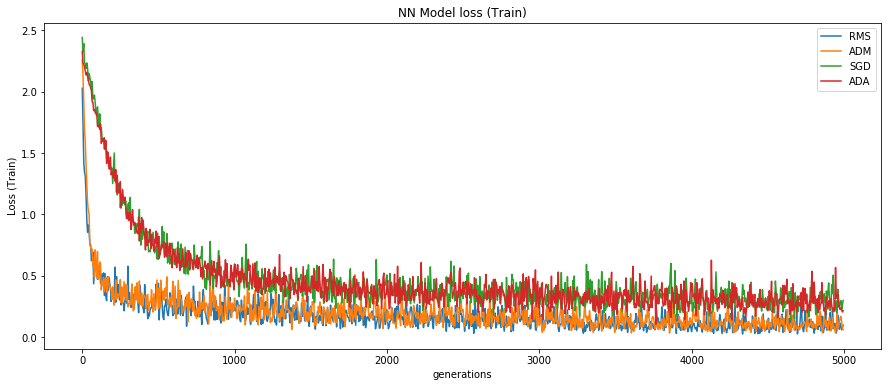

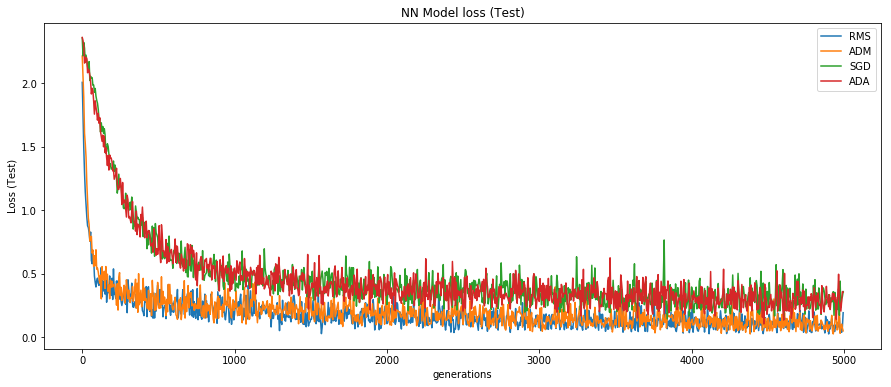

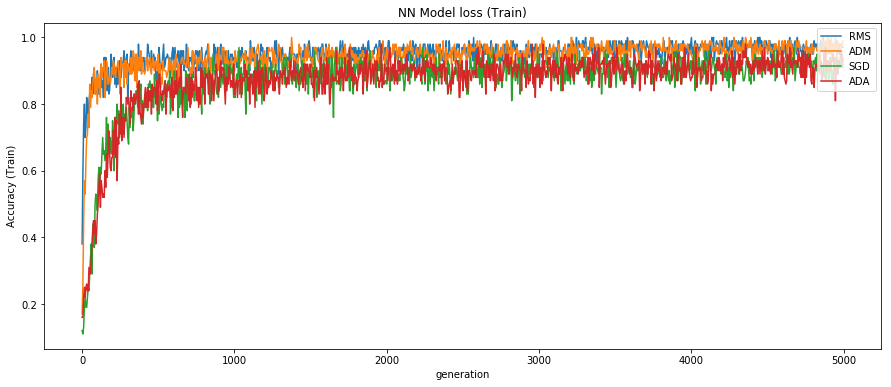

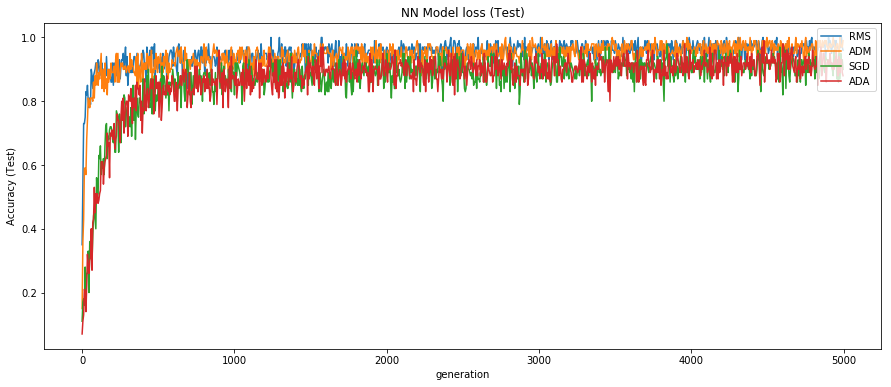

In [274]:
plt.rcParams["figure.figsize"] = [15,6]

plt.plot(eval_indices, a_l_nn_2_d_rms[0])
plt.plot(eval_indices, a_l_nn_2_d_adm[0])
plt.plot(eval_indices, a_l_nn_2_d_sgd[0])
plt.plot(eval_indices, a_l_nn_2_d_ada[0])

plt.title('NN Model loss (Train)')
plt.ylabel('Loss (Train)')
plt.xlabel('generations')
plt.legend(['RMS', 'ADM', 'SGD', 'ADA'], loc='upper right')
plt.show()

plt.plot(eval_indices, a_l_nn_2_d_rms[1])
plt.plot(eval_indices, a_l_nn_2_d_adm[1])
plt.plot(eval_indices, a_l_nn_2_d_sgd[1])
plt.plot(eval_indices, a_l_nn_2_d_ada[1])

plt.title('NN Model loss (Test)')
plt.ylabel('Loss (Test)')
plt.xlabel('generations')
plt.legend(['RMS', 'ADM', 'SGD', 'ADA'], loc='upper right')
plt.show()

plt.plot(eval_indices, a_l_nn_2_d_rms[2])
plt.plot(eval_indices, a_l_nn_2_d_adm[2])
plt.plot(eval_indices, a_l_nn_2_d_sgd[2])
plt.plot(eval_indices, a_l_nn_2_d_ada[2])

plt.title('NN Model loss (Train)')
plt.ylabel('Accuracy (Train)')
plt.xlabel('generation')
plt.legend(['RMS', 'ADM', 'SGD', 'ADA'], loc='upper right')
plt.show()

plt.plot(eval_indices, a_l_nn_2_d_rms[3])
plt.plot(eval_indices, a_l_nn_2_d_adm[3])
plt.plot(eval_indices, a_l_nn_2_d_sgd[3])
plt.plot(eval_indices, a_l_nn_2_d_ada[3])

plt.title('NN Model loss (Test)')
plt.ylabel('Accuracy (Test)')
plt.xlabel('generation')
plt.legend(['RMS', 'ADM', 'SGD', 'ADA'], loc='upper right')
plt.show()

### RMS and ADM works better 

## RNN Model (LSTM_1 -> LSTM_2 -> Fully_con_1 -> Fully_con_2)

In [25]:
generations_rnn = 1000
evaluation_size = 200
eval_indices_rnn = range(0, generations_rnn, eval_every)

In [18]:
%%time
a_l_lstm_2_nn_2_d_rms = model_run('LSTM_2_NN_2', train_x, train_y, test_x, test_y, batch_size, generations_rnn, DROP_OUT = True, OPT = 'RMS')

Generation # 200. Train Loss (Test Loss): 1.05 (1.23). Train Acc (Test Acc): 0.63 (0.50)
Generation # 400. Train Loss (Test Loss): 0.59 (0.75). Train Acc (Test Acc): 0.76 (0.76)
Generation # 600. Train Loss (Test Loss): 0.49 (0.39). Train Acc (Test Acc): 0.83 (0.91)
Generation # 800. Train Loss (Test Loss): 0.30 (0.33). Train Acc (Test Acc): 0.93 (0.87)
Generation # 1000. Train Loss (Test Loss): 0.23 (0.66). Train Acc (Test Acc): 0.94 (0.88)
Wall time: 2min 15s


In [19]:
%%time
a_l_lstm_2_nn_2_nd_rms = model_run('LSTM_2_NN_2', train_x, train_y, test_x, test_y, batch_size, generations_rnn, DROP_OUT = False, OPT = 'RMS')

Generation # 200. Train Loss (Test Loss): 0.71 (0.72). Train Acc (Test Acc): 0.75 (0.76)
Generation # 400. Train Loss (Test Loss): 0.90 (0.61). Train Acc (Test Acc): 0.70 (0.81)
Generation # 600. Train Loss (Test Loss): 0.17 (0.27). Train Acc (Test Acc): 0.96 (0.94)
Generation # 800. Train Loss (Test Loss): 0.18 (0.30). Train Acc (Test Acc): 0.93 (0.92)
Generation # 1000. Train Loss (Test Loss): 0.12 (0.16). Train Acc (Test Acc): 0.95 (0.94)
Wall time: 2min 14s


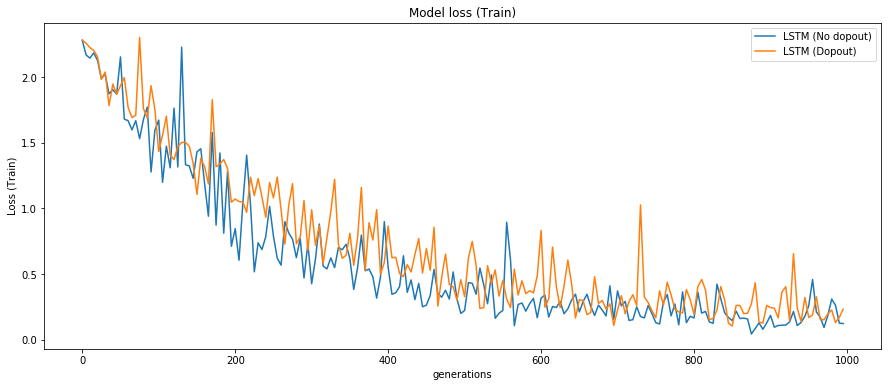

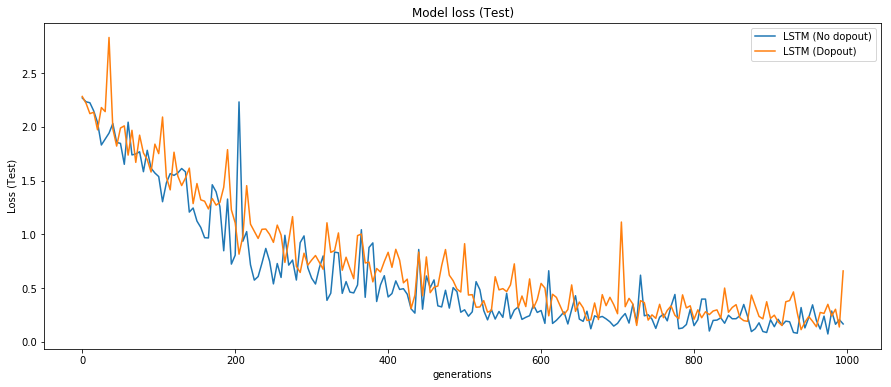

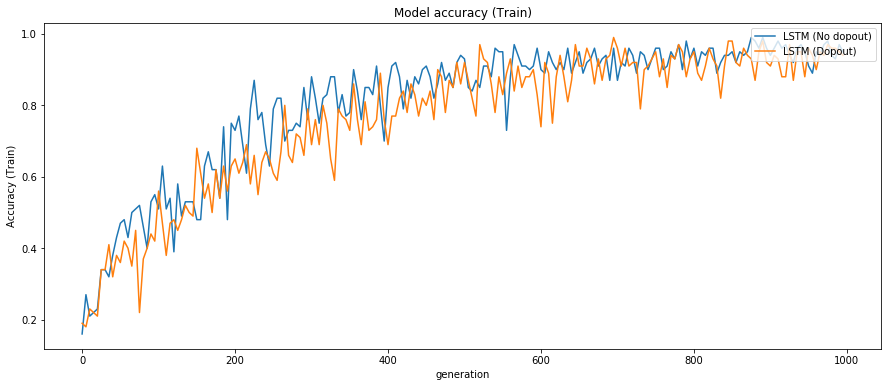

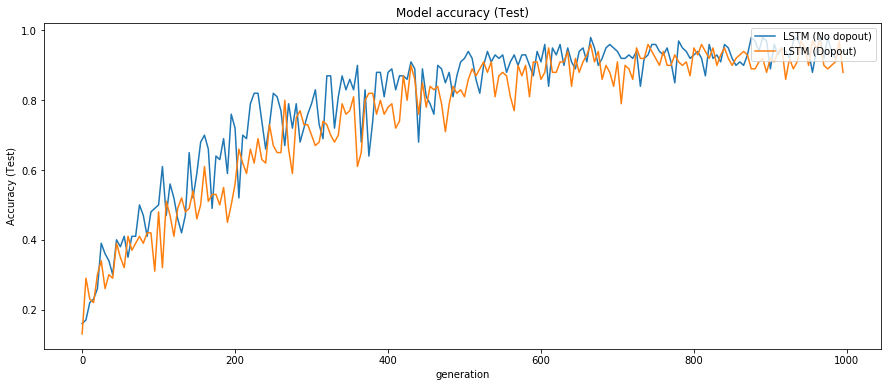

In [23]:
plt.rcParams["figure.figsize"] = [15,6]

plt.plot(eval_indices_rnn, a_l_lstm_2_nn_2_nd_rms[0])
plt.plot(eval_indices_rnn, a_l_lstm_2_nn_2_d_rms[0])
plt.title('Model loss (Train)')
plt.ylabel('Loss (Train)')
plt.xlabel('generations')
plt.legend(['LSTM (No dopout)', 'LSTM (Dopout)'], loc='upper right')
plt.show()

plt.plot(eval_indices_rnn, a_l_lstm_2_nn_2_nd_rms[1])
plt.plot(eval_indices_rnn, a_l_lstm_2_nn_2_d_rms[1])
plt.title('Model loss (Test)')
plt.ylabel('Loss (Test)')
plt.xlabel('generations')
plt.legend(['LSTM (No dopout)', 'LSTM (Dopout)'], loc='upper right')
plt.show()

plt.plot(eval_indices_rnn, a_l_lstm_2_nn_2_nd_rms[2])
plt.plot(eval_indices_rnn, a_l_lstm_2_nn_2_d_rms[2])
plt.title('Model accuracy (Train)')
plt.ylabel('Accuracy (Train)')
plt.xlabel('generation')
plt.legend(['LSTM (No dopout)', 'LSTM (Dopout)'], loc='upper right')
plt.show()

plt.plot(eval_indices_rnn, a_l_lstm_2_nn_2_nd_rms[3])
plt.plot(eval_indices_rnn, a_l_lstm_2_nn_2_d_rms[3])
plt.title('Model accuracy (Test)')
plt.ylabel('Accuracy (Test)')
plt.xlabel('generation')
plt.legend(['LSTM (No dopout)', 'LSTM (Dopout)'], loc='upper right')
plt.show()

### Neet run more generations. Dropout are expected to overcome overfiting

### Compare different optimizers for LSTM with default learning_rate

In [26]:
%%time
a_l_lstm_2_nn_2_d_rms = model_run('LSTM_2_NN_2', train_x, train_y, test_x, test_y, batch_size, generations_rnn, DROP_OUT = True, OPT = 'RMS')

Generation # 200. Train Loss (Test Loss): 1.14 (1.01). Train Acc (Test Acc): 0.55 (0.69)
Generation # 400. Train Loss (Test Loss): 0.77 (0.61). Train Acc (Test Acc): 0.79 (0.82)
Generation # 600. Train Loss (Test Loss): 0.25 (0.28). Train Acc (Test Acc): 0.93 (0.90)
Generation # 800. Train Loss (Test Loss): 0.26 (0.20). Train Acc (Test Acc): 0.94 (0.95)
Generation # 1000. Train Loss (Test Loss): 0.23 (0.19). Train Acc (Test Acc): 0.94 (0.94)
Wall time: 1min 53s


In [27]:
%%time
a_l_lstm_2_nn_2_d_adm = model_run('LSTM_2_NN_2', train_x, train_y, test_x, test_y, batch_size, generations_rnn, DROP_OUT = True, OPT = 'ADM')

Generation # 200. Train Loss (Test Loss): 0.82 (0.87). Train Acc (Test Acc): 0.68 (0.67)
Generation # 400. Train Loss (Test Loss): 0.50 (0.56). Train Acc (Test Acc): 0.87 (0.86)
Generation # 600. Train Loss (Test Loss): 0.43 (0.41). Train Acc (Test Acc): 0.88 (0.92)
Generation # 800. Train Loss (Test Loss): 0.15 (0.29). Train Acc (Test Acc): 0.96 (0.92)
Generation # 1000. Train Loss (Test Loss): 0.14 (0.13). Train Acc (Test Acc): 0.97 (0.97)
Wall time: 1min 55s


In [28]:
%%time
a_l_lstm_2_nn_2_d_sgd = model_run('LSTM_2_NN_2', train_x, train_y, test_x, test_y, batch_size, generations_rnn, DROP_OUT = True, OPT = 'SGD')

Generation # 200. Train Loss (Test Loss): 2.30 (2.30). Train Acc (Test Acc): 0.11 (0.18)
Generation # 400. Train Loss (Test Loss): 2.29 (2.29). Train Acc (Test Acc): 0.16 (0.23)
Generation # 600. Train Loss (Test Loss): 2.29 (2.29). Train Acc (Test Acc): 0.15 (0.14)
Generation # 800. Train Loss (Test Loss): 2.29 (2.28). Train Acc (Test Acc): 0.15 (0.15)
Generation # 1000. Train Loss (Test Loss): 2.28 (2.28). Train Acc (Test Acc): 0.17 (0.16)
Wall time: 1min 54s


In [29]:
%%time
a_l_lstm_2_nn_2_d_ada = model_run('LSTM_2_NN_2', train_x, train_y, test_x, test_y, batch_size, generations_rnn, DROP_OUT = True, OPT = 'ADA')

Generation # 200. Train Loss (Test Loss): 2.30 (2.30). Train Acc (Test Acc): 0.10 (0.15)
Generation # 400. Train Loss (Test Loss): 2.28 (2.29). Train Acc (Test Acc): 0.20 (0.17)
Generation # 600. Train Loss (Test Loss): 2.28 (2.28). Train Acc (Test Acc): 0.25 (0.16)
Generation # 800. Train Loss (Test Loss): 2.27 (2.27). Train Acc (Test Acc): 0.22 (0.24)
Generation # 1000. Train Loss (Test Loss): 2.24 (2.24). Train Acc (Test Acc): 0.29 (0.25)
Wall time: 1min 54s


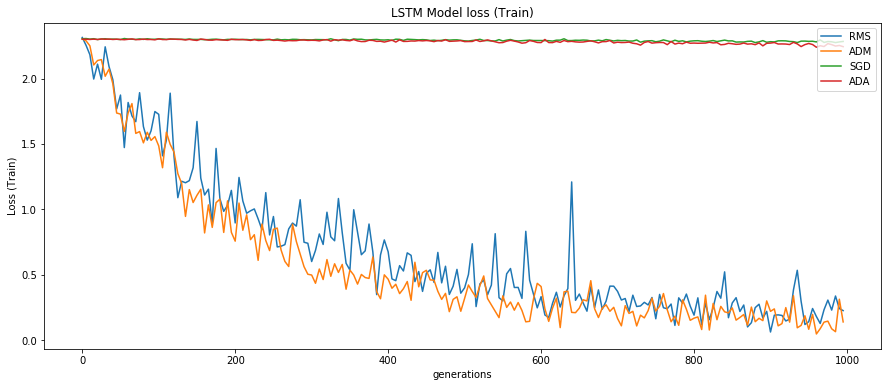

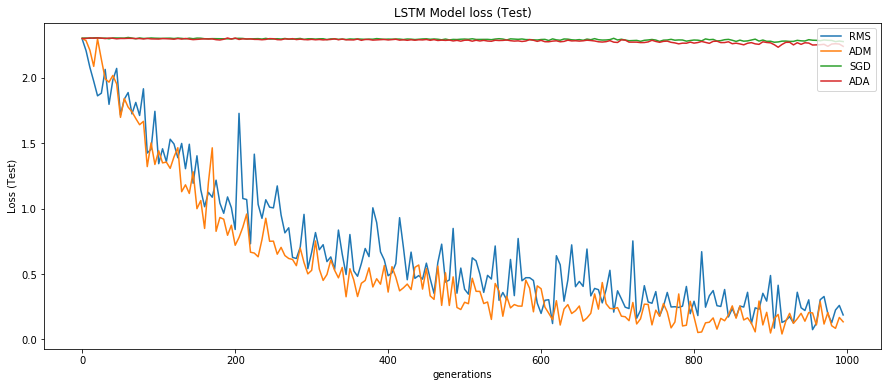

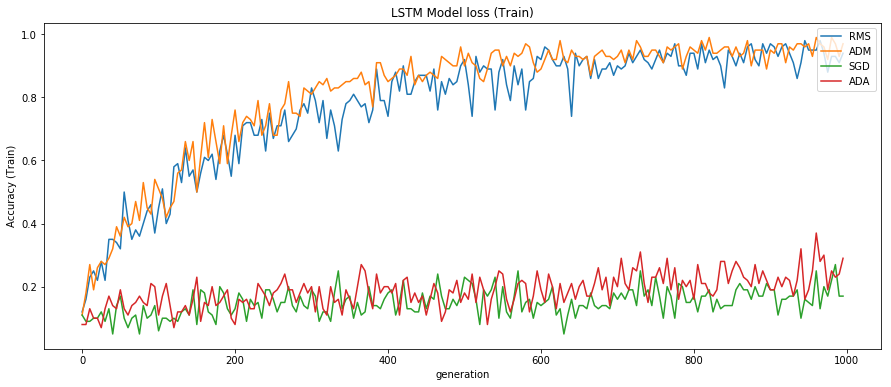

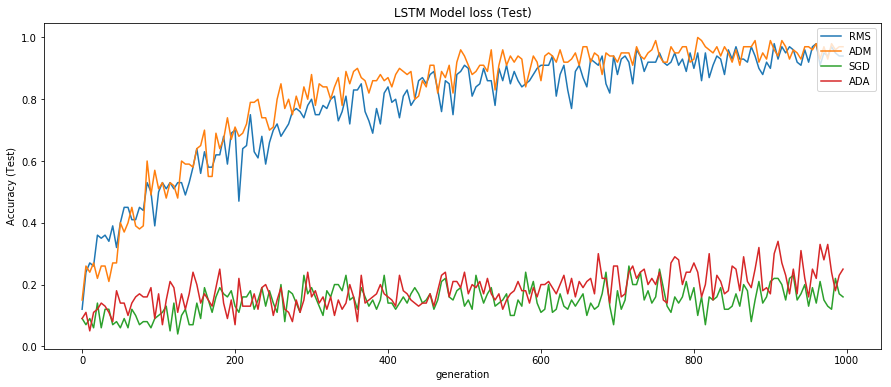

In [33]:
plt.rcParams["figure.figsize"] = [15,6]

plt.plot(eval_indices, a_l_lstm_2_nn_2_d_rms[0])
plt.plot(eval_indices, a_l_lstm_2_nn_2_d_adm[0])
plt.plot(eval_indices, a_l_lstm_2_nn_2_d_sgd[0])
plt.plot(eval_indices, a_l_lstm_2_nn_2_d_ada[0])

plt.title('LSTM Model loss (Train)')
plt.ylabel('Loss (Train)')
plt.xlabel('generations')
plt.legend(['RMS', 'ADM', 'SGD', 'ADA'], loc='upper right')
plt.show()

plt.plot(eval_indices, a_l_lstm_2_nn_2_d_rms[1])
plt.plot(eval_indices, a_l_lstm_2_nn_2_d_adm[1])
plt.plot(eval_indices, a_l_lstm_2_nn_2_d_sgd[1])
plt.plot(eval_indices, a_l_lstm_2_nn_2_d_ada[1])

plt.title('LSTM Model loss (Test)')
plt.ylabel('Loss (Test)')
plt.xlabel('generations')
plt.legend(['RMS', 'ADM', 'SGD', 'ADA'], loc='upper right')
plt.show()

plt.plot(eval_indices, a_l_lstm_2_nn_2_d_rms[2])
plt.plot(eval_indices, a_l_lstm_2_nn_2_d_adm[2])
plt.plot(eval_indices, a_l_lstm_2_nn_2_d_sgd[2])
plt.plot(eval_indices, a_l_lstm_2_nn_2_d_ada[2])

plt.title('LSTM Model loss (Train)')
plt.ylabel('Accuracy (Train)')
plt.xlabel('generation')
plt.legend(['RMS', 'ADM', 'SGD', 'ADA'], loc='upper right')
plt.show()

plt.plot(eval_indices, a_l_lstm_2_nn_2_d_rms[3])
plt.plot(eval_indices, a_l_lstm_2_nn_2_d_adm[3])
plt.plot(eval_indices, a_l_lstm_2_nn_2_d_sgd[3])
plt.plot(eval_indices, a_l_lstm_2_nn_2_d_ada[3])

plt.title('LSTM Model loss (Test)')
plt.ylabel('Accuracy (Test)')
plt.xlabel('generation')
plt.legend(['RMS', 'ADM', 'SGD', 'ADA'], loc='upper right')
plt.show()

## We may not trust default learning rate.
## I found some methods to choose learning rate: 
## https://medium.com/octavian-ai/which-optimizer-and-learning-rate-should-i-use-for-deep-learning-5acb418f9b2